<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploring-Distribution-of-Stock-Returns" data-toc-modified-id="Exploring-Distribution-of-Stock-Returns-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exploring Distribution of Stock Returns</a></span><ul class="toc-item"><li><span><a href="#Description-of-Data" data-toc-modified-id="Description-of-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Description of Data</a></span><ul class="toc-item"><li><span><a href="#Data-and-processing" data-toc-modified-id="Data-and-processing-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Data and processing</a></span></li><li><span><a href="#Descriptive-Statistics" data-toc-modified-id="Descriptive-Statistics-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Descriptive Statistics</a></span></li></ul></li><li><span><a href="#Autocorrelation-in-Log-Returns" data-toc-modified-id="Autocorrelation-in-Log-Returns-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Autocorrelation in Log Returns</a></span><ul class="toc-item"><li><span><a href="#Log-Returns" data-toc-modified-id="Log-Returns-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Log Returns</a></span></li><li><span><a href="#Squared-Log-Returns" data-toc-modified-id="Squared-Log-Returns-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Squared Log Returns</a></span></li></ul></li><li><span><a href="#Stationarity" data-toc-modified-id="Stationarity-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Stationarity</a></span></li></ul></li></ul></div>

# Exploring Distribution of Stock Returns

The following notebook uses the methodology outlined in the following paper, with the caveat that it is applied to the Singapore Exchange(SGX) rather than the OBX Index:

https://ntnuopen.ntnu.no/ntnu-xmlui/bitstream/handle/11250/2573100/19926_FULLTEXT.pdf?sequence=1&isAllowed=y

## Description of Data

### Data and processing

The Straits Times Index (STI) is a market capitalisation weighted index that tracks the performance of the top 30 companies listed on SGX. The paper suggests picking ten stocks in total based on *market capitalisation* as well *volatility*. In addition, to ensure that there is sufficient historical data for backtesting, we only consider stocks that has data spanning back to 2010-01-01.

In [1]:
# Scrape constitutents and market cap from sginvestors.io
import requests
from bs4 import BeautifulSoup

res = requests.get('https://sginvestors.io/analysts/sti-straits-times-index-constituents-target-price')
soup = BeautifulSoup(res.content, 'html.parser')
tickers = [i.text[i.text.find("(")+1:i.text.find(")")] for i in soup.find_all('td', class_='text-primary')]
market_caps = [i.text for i in soup.find_all('td', class_="text-right") if i.text[-1] == 'B'][::2][:-1]
market_caps = [float(i[:-1]) for i in market_caps]

In [2]:
print('Ticker:', tickers[0])
print('Market Cap (Billion)', market_caps[0])

Ticker: A17U.SI
Market Cap (Billion) 10.8


In [3]:
# Get historical price data
from yahooquery import Ticker
import pandas as pd

start_date = pd.to_datetime('2010-01-01')
dfs, columns = [], []

for ticker in tickers:
    yq = Ticker(ticker).history(period='max', interval='1d')
    yq.reset_index(inplace=True)
    yq.drop('symbol', axis=1, inplace=True)
    yq.set_index('date', inplace=True)
    yq.index = pd.to_datetime(yq.index)
    if yq.index[0] <= start_date:
        yq = yq[yq.index >= start_date]['adjclose']
        dfs.append(yq)
        columns.append(ticker)

In [4]:
price = pd.concat(dfs, axis=1)
price.columns = columns
price.head(5)

,A17U.SI,C52.SI,D05.SI,V03.SI,Y92.SI,F34.SI,Z74.SI,C09.SI,BN4.SI,U11.SI,...,S68.SI,C6L.SI,G13.SI,S58.SI,U14.SI,C07.SI,C38U.SI,H78.SI,J36.SI,J37.SI
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.054681,1.043654,10.017633,4.692375,9.095976e-07,4.932097,1.885529,10.318144,4.681181,13.692189,...,5.445680,11.787917,1.066994,1.826332,3.136039,18.653389,1.046137,3.601946,22.596851,16.096577
2010-01-05,1.049703,1.056539,10.148582,4.756507,9.281610e-07,5.093178,1.879505,10.765204,4.743443,13.664332,...,5.478644,11.662678,1.058723,1.778807,3.151300,18.791033,1.069384,3.587420,22.476330,15.932694
2010-01-06,1.044730,1.056539,10.148582,4.858052,9.281610e-07,5.208235,1.867457,10.461203,4.766088,13.859340,...,5.498424,11.553098,1.050452,1.744860,3.158930,18.722176,1.075196,3.536588,22.596851,15.969111
2010-01-07,1.024828,1.043654,10.030727,4.906151,9.281610e-07,5.185222,1.825288,10.336028,4.918915,13.859340,...,5.577537,11.302623,1.025638,1.785596,3.113148,18.543203,1.069384,3.471231,22.943333,16.078369
2010-01-08,1.009904,1.050096,10.070014,4.916840,9.095976e-07,5.292610,1.837337,10.407557,4.896276,13.873263,...,5.537980,11.333932,1.025638,1.812754,3.105518,18.226582,1.086820,3.522063,23.033722,15.987324


In [5]:
# Identify firms with top five highest market cap
top_5_marketcap = pd.DataFrame({'market_cap': market_caps}, index=tickers).sort_values(by='market_cap', ascending=False)[:5].index.values

# Now get standard deviation and get top five most volatile (exluding larget market cap stocks)
current_selection = price[top_5_marketcap]
vol_test = price.drop(top_5_marketcap, axis=1)
top_5_mostvol = vol_test.std().sort_values(ascending=False)[:5].index.values

# Combine and save csv file
top10 = pd.concat([current_selection, price[top_5_mostvol]], axis=1)
top10.to_csv('data/top10.csv')

In [6]:
# Compute log returns and save csv file
import numpy as np

log_returns = np.log(top10 / top10.shift(1)).dropna()
log_returns.to_csv('data/top10_logreturns.csv')

### Descriptive Statistics

I split the data into two periods. 2010-01-01 to 2015-12-31 for analysis, and 2016-01-01 to present for forecasting.

In [7]:
import pandas as pd

cutoff_date = pd.to_datetime('2015-12-31')
log_returns = pd.read_csv('data/top10_logreturns.csv', index_col=0, parse_dates=True)
train = log_returns[log_returns.index <= cutoff_date]
test = log_returns[log_returns.index > cutoff_date]
print('No. of observations for analysis:', len(train))
print('No. of observations for forecasting:', len(test))

No. of observations for analysis: 1503
No. of observations for forecasting: 1229


And now statistics are calculated:

In [8]:
from scipy import stats

mean = train.mean()
std = train.std()
var = train.var()
minimum = train.min()
maximum = train.max()
skew = stats.skew(train)
excess_kurtosis = stats.kurtosis(train)

summary_statistics = pd.DataFrame({'stock': log_returns.columns.values,
                                   'mean': mean,
                                   'stdev': std,
                                   'variance': var,
                                   'min': minimum,
                                   'max': maximum,
                                   'skew': skew,
                                   'excess_kurt': excess_kurtosis
                                  })

summary_statistics.set_index('stock', inplace=True)

# also add column for reason for addition: 'reason'
summary_statistics['reason'] = np.where(summary_statistics.index.isin(top_5_mostvol), 'Volatile', 'Market Cap')
summary_statistics

,mean,stdev,variance,min,max,skew,excess_kurt,reason
stock,,,,,,,,
D05.SI,0.000185,0.010540,0.000111,-0.061544,0.044862,-0.242291,2.630340,Market Cap
J36.SI,0.000420,0.016819,0.000283,-0.067416,0.065642,0.122271,1.109138,Market Cap
O39.SI,0.000140,0.010019,0.000100,-0.044951,0.045699,-0.002714,1.616836,Market Cap
Z74.SI,0.000289,0.010852,0.000118,-0.054067,0.044336,-0.154556,1.202005,Market Cap
U11.SI,0.000132,0.011305,0.000128,-0.055621,0.046064,-0.108378,1.517346,Market Cap
J37.SI,0.000321,0.016332,0.000267,-0.071424,0.088469,0.281388,2.030069,Volatile
C07.SI,0.000287,0.018357,0.000337,-0.086534,0.089136,0.375939,2.567654,Volatile
V03.SI,0.000198,0.010055,0.000101,-0.046079,0.046908,0.051869,2.315878,Volatile
C6L.SI,-0.000104,0.011511,0.000132,-0.101219,0.061055,-0.347364,5.802146,Volatile


All of the stocks have positive excess kurtosis and are hence *leptokurtic*. This, together with the non-zero skew values, implies that the return distribution most likely does not follow a normal distribution. To confirm this, I perform the Jarque Bera test:

In [9]:
pvals = []
for col in train.columns:
    pvals.append(stats.jarque_bera(train[col])[1])
pvals # null hypothesis of (log) normality can be rejected

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Autocorrelation in Log Returns

### Log Returns

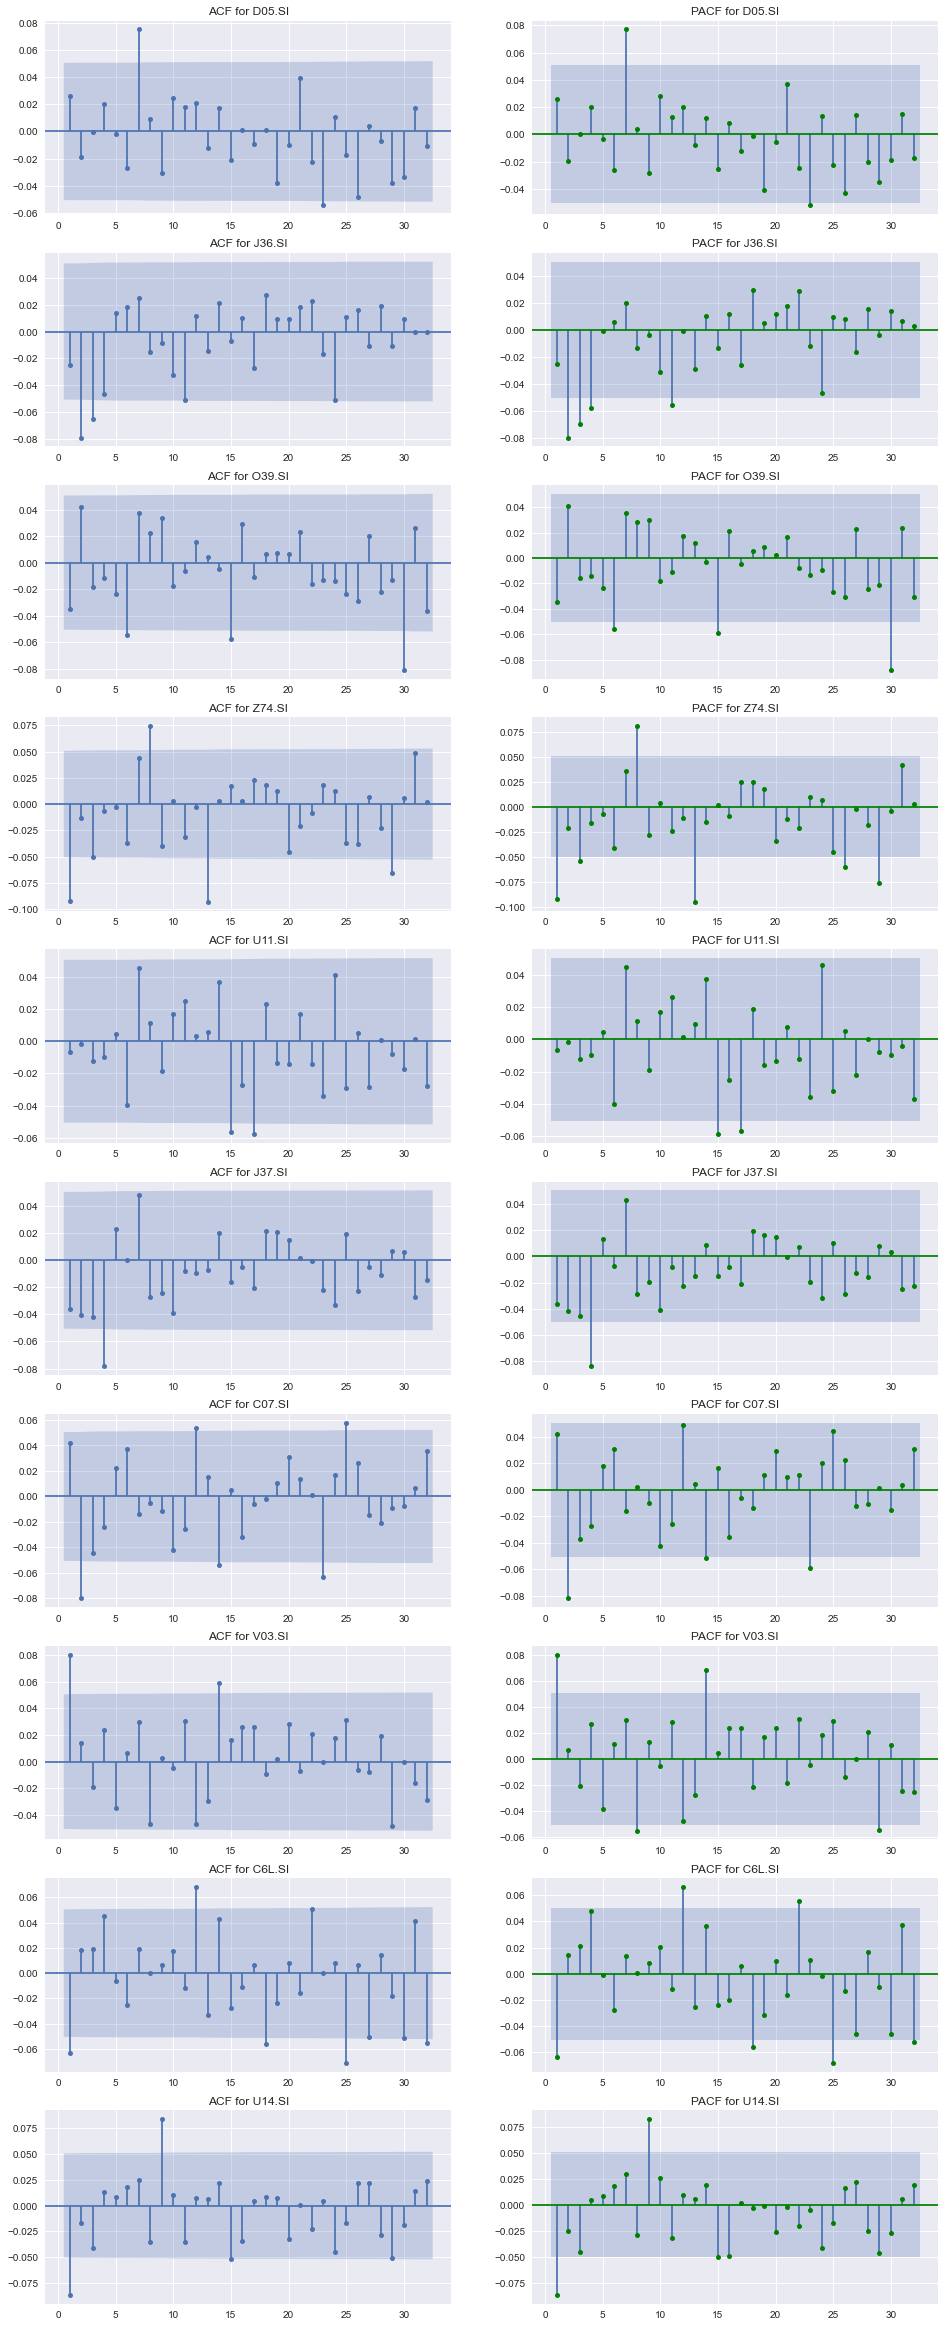

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig, axes = plt.subplots(10, 2, figsize=(16, 42))

for i in range(10):
    plot_acf(train.iloc(axis=1)[i], ax=axes[i, 0], title='ACF for ' + train.columns[i], zero=False)
    plot_pacf(train.iloc(axis=1)[i], ax=axes[i, 1], title='PACF for ' + train.columns[i], color='green', zero=False)

Viewing the above plots reveals that some of the stocks do indeed exhibit significant serial autocorrelation, which suggests the presence of an arbitrage opportunity.

### Squared Log Returns

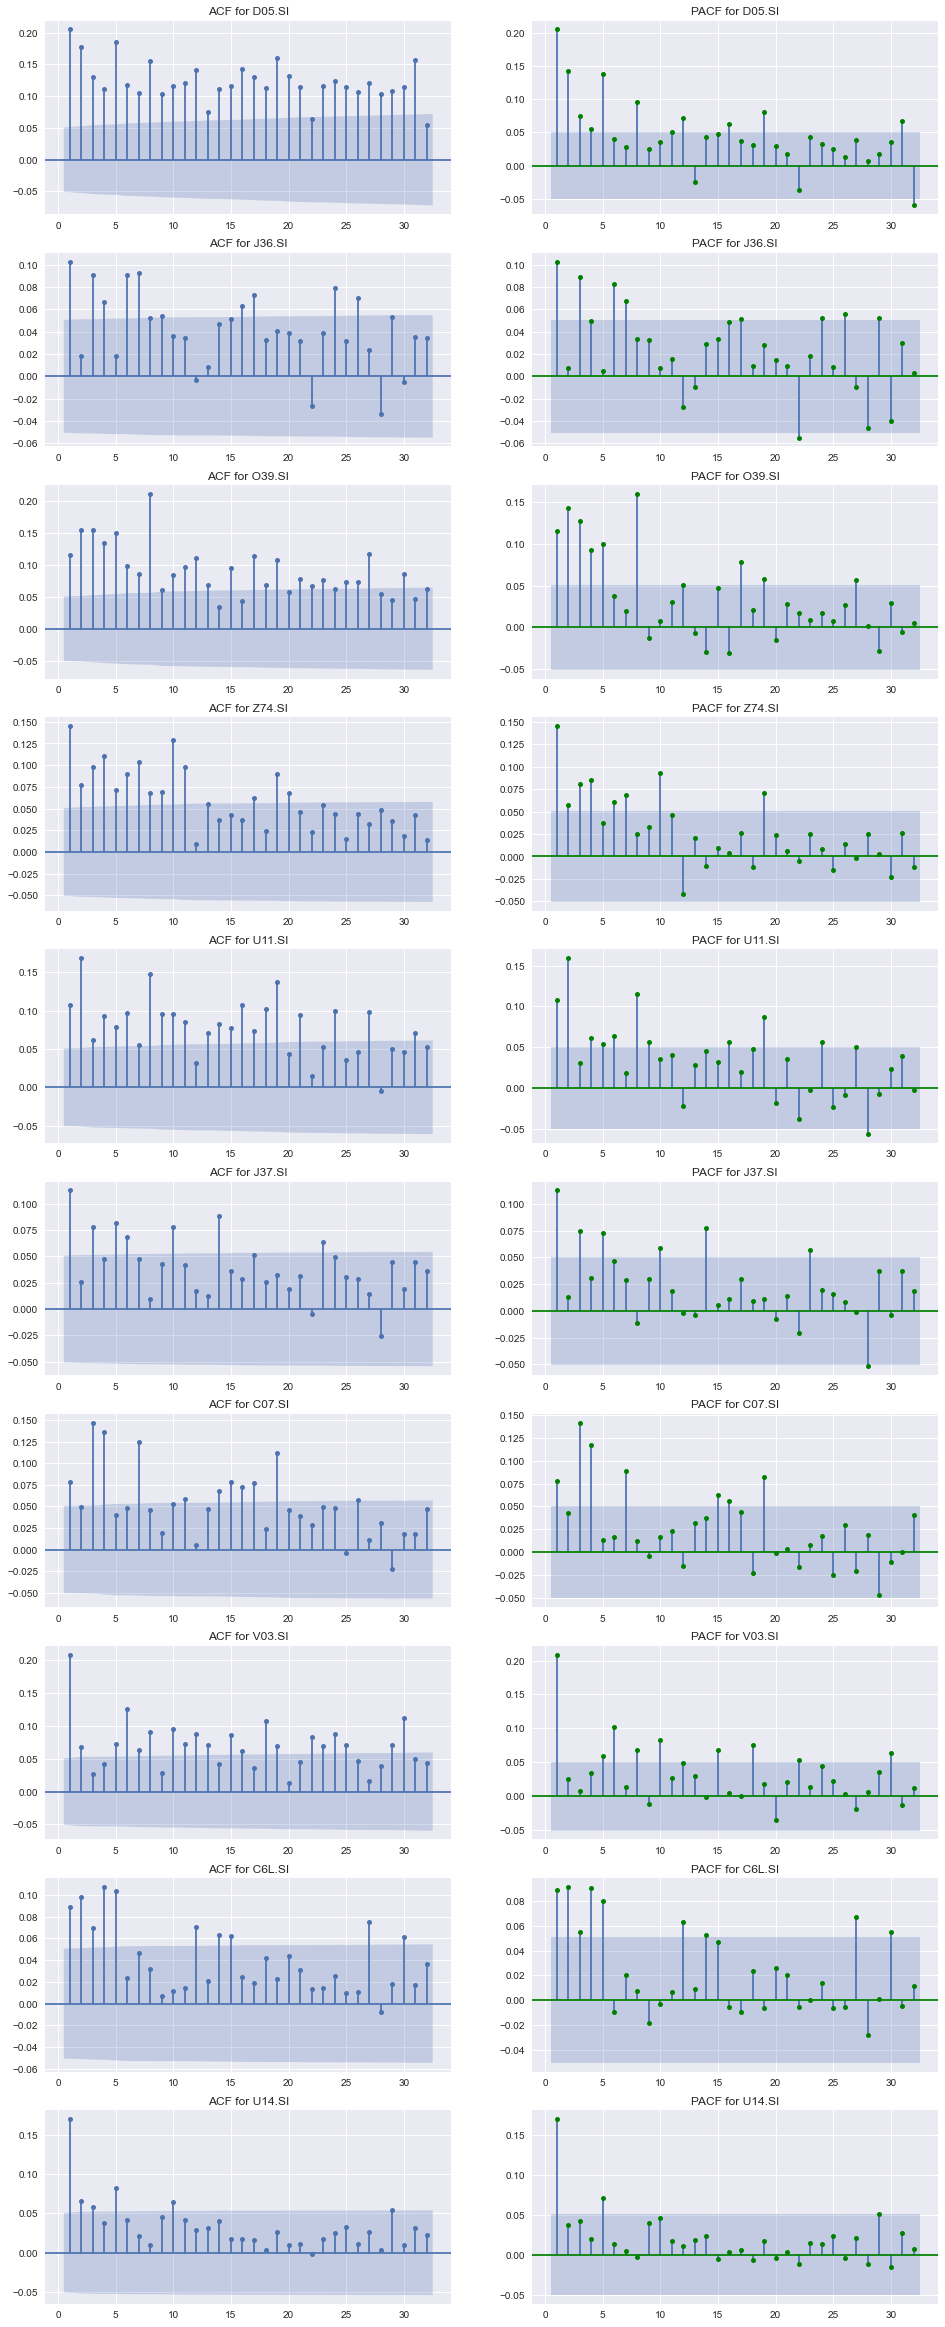

In [11]:
fig, axes = plt.subplots(10, 2, figsize=(16, 42))

for i in range(10):
    plot_acf(train.iloc(axis=1)[i]**2, ax=axes[i, 0], title='ACF for ' + train.columns[i], zero=False)
    plot_pacf(train.iloc(axis=1)[i]**2, ax=axes[i, 1], title='PACF for ' + train.columns[i], color='green', zero=False)

There is significant autocorrelation at almost every time lag for the squared log returns, which indicates the presence of volatility clustering in the return series.

## Stationarity

Perform the Augmented Dickey-Fuller unit-root test to check for stationarity in log returns:

In [12]:
from statsmodels.tsa.stattools import adfuller

adf_pvals = []

for i in range(10):
    adf_pvals.append(adfuller(train.iloc(axis=1)[i], maxlag=0)[1])

In [13]:
adf_pvals # reject null hypothesis for presence of unit root - time series are stationary

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]